# **NHẬP MÔN HỌC MÁY**
## **PHASE 3**
### Lớp: CQ2022/24
### Thông tin thành viên
|MSSV|Họ và tên|
|-|-|
|22120214| Trương Thị Tú My|
|22120389| Dương Ngọc Kiều Trinh|
|22120422| Nguyễn Phạm Tú Uyên|
#
---

### Import

In [1]:
# import các thư viện cần thiết
import json
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Tắt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Thiết lập seed
np.random.seed(seed=42)
torch.manual_seed(seed=42)
torch.cuda.manual_seed(seed=42)

### Đọc dữ liệu

In [ ]:
def load_data(json_path, is_train=True):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    records = []

    for item in data:
        record = {
            'vid_id': item['vid_id'],
            'audio_embedding': item['audio_embedding']
        }

        if is_train:
            record['is_turkey'] = item['is_turkey']
        
        records.append(record)
    
    return records

Đọc dữ liệu từ file json

In [5]:
# Đọc dữ liệu train
train_data = load_data('./data/train.json', is_train=True)

### **I. Phát triển mô hình**

#### 1. Chuẩn bị dữ liệu

Chia tập train thành 3 phần train, validation và test với tỷ lệ 70:15:15

In [6]:
labels = [r['is_turkey'] for r in train_data]
temp_records, test_records = train_test_split(train_data, test_size=0.15, random_state=42, stratify=labels)

temp_labels = [r['is_turkey'] for r in temp_records]
train_records, valid_records = train_test_split(temp_records, test_size=0.1765, random_state=42, stratify=temp_labels)

Hàm tạo dataset với embedding được chuẩn hóa độ dài

In [7]:
class AudioDataset(Dataset):
    def __init__(self, records, max_len=10, is_train=True):
        self.records = records
        self.max_len = max_len
        self.is_train = is_train

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        item = self.records[idx]
        embedding = torch.tensor(item['audio_embedding'], dtype=torch.float32)

        # Đảm bảo chiều dài cố định
        if embedding.size(0) < self.max_len:
            pad_len = self.max_len - embedding.size(0)
            pad = torch.zeros(pad_len, 128)
            embedding = torch.cat([embedding, pad], dim=0)
        else:
            embedding = embedding[:self.max_len]

        if self.is_train:
            label = torch.tensor(item['is_turkey'], dtype=torch.float32)
            return embedding, label
        else:
            return embedding, 0

Chuẩn hóa độ dài embedding của 3 tập train, valid, test

In [8]:
train_dataset = AudioDataset(train_records, max_len=10, is_train=True)
valid_dataset = AudioDataset(valid_records, max_len=10, is_train=True)
test_dataset = AudioDataset(test_records, max_len=10, is_train=True)  

Chia tập train và valid thành các nhóm nhỏ (batch)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

#### 2. Huấn luyện mô hình

Mô hình AudioClassifier định nghĩa kiến trúc Transformer, phân loại nhị phân dựa trên 'audio_embedding'

In [10]:
class AudioClassifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=256, num_heads=4, num_layers=2, dropout=0.2):
        super(AudioClassifier, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        return self.fc(x).squeeze(-1)

Hàm huấn luyện mô hình với dữ liệu train và đánh giá trên valid, chọn ra mô hình tốt nhất dựa trên AUC

In [11]:
def train_model(model, train_loader, valid_loader, epochs=30):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

    best_score = 0
    best_model = None
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for x, y in valid_loader:
                out = torch.sigmoid(model(x))
                preds.extend(out.numpy())
                labels.extend(y.numpy())

        auc = roc_auc_score(labels, preds)
        scheduler.step(1 - auc)
        if auc > best_score:
            best_score = auc
            best_model = model.state_dict()
        print(f"Epoch {epoch + 1}, Validation AUC: {auc:.4f}")

    model.load_state_dict(best_model)
    return model

Định nghĩa mô hình và huấn luyện mô hình, chọn ra mô hình với thông số tốt nhất

In [12]:
model = AudioClassifier()
model = train_model(model, train_loader, valid_loader)

Epoch 1, Validation AUC: 0.9793
Epoch 2, Validation AUC: 0.9830
Epoch 3, Validation AUC: 0.9841
Epoch 4, Validation AUC: 0.9861
Epoch 5, Validation AUC: 0.9864
Epoch 6, Validation AUC: 0.9871
Epoch 7, Validation AUC: 0.9873
Epoch 8, Validation AUC: 0.9888
Epoch 9, Validation AUC: 0.9899
Epoch 10, Validation AUC: 0.9878
Epoch 11, Validation AUC: 0.9865
Epoch 12, Validation AUC: 0.9869
Epoch 13, Validation AUC: 0.9853
Epoch 14, Validation AUC: 0.9858
Epoch 15, Validation AUC: 0.9871
Epoch 16, Validation AUC: 0.9871
Epoch 17, Validation AUC: 0.9876
Epoch 18, Validation AUC: 0.9876
Epoch 19, Validation AUC: 0.9876
Epoch 20, Validation AUC: 0.9876
Epoch 21, Validation AUC: 0.9876
Epoch 22, Validation AUC: 0.9876
Epoch 23, Validation AUC: 0.9876
Epoch 24, Validation AUC: 0.9876
Epoch 25, Validation AUC: 0.9876
Epoch 26, Validation AUC: 0.9876
Epoch 27, Validation AUC: 0.9876
Epoch 28, Validation AUC: 0.9876
Epoch 29, Validation AUC: 0.9876
Epoch 30, Validation AUC: 0.9876


### **II. Đánh giá mô hình**

Hàm đánh giá hiệu suất mô hình trên tập test và trực quan

In [13]:
def evaluate_model(model, dataset):
    model.eval()
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            out = torch.sigmoid(model(x))
            preds.extend(out.numpy())
            labels.extend(y.numpy())
    
    auc = roc_auc_score(labels, preds)
    acc = accuracy_score(labels, [p > 0.5 for p in preds])
    prec = precision_score(labels, [p > 0.5 for p in preds])
    rec = recall_score(labels, [p > 0.5 for p in preds])

    print(f"AUC: {auc:.4f}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

    bin_preds = [p > 0.5 for p in preds]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    cm = confusion_matrix(labels, bin_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Turkey", "Turkey"], yticklabels=["Not Turkey", "Turkey"], ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    report = classification_report(labels, bin_preds, output_dict=True, target_names=["Not Turkey", "Turkey"])
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, fmt=".2f", cmap="Blues", ax=axes[1])
    axes[1].set_title("Classification Report")
    axes[1].set_ylabel("Metrics")

    fpr, tpr, _ = roc_curve(labels, preds)
    axes[2].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[2].set_xlabel("False Positive Rate")
    axes[2].set_ylabel("True Positive Rate")
    axes[2].set_title("ROC Curve")
    axes[2].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

AUC: 0.9922, Accuracy: 0.9667, Precision: 0.9474, Recall: 0.9730


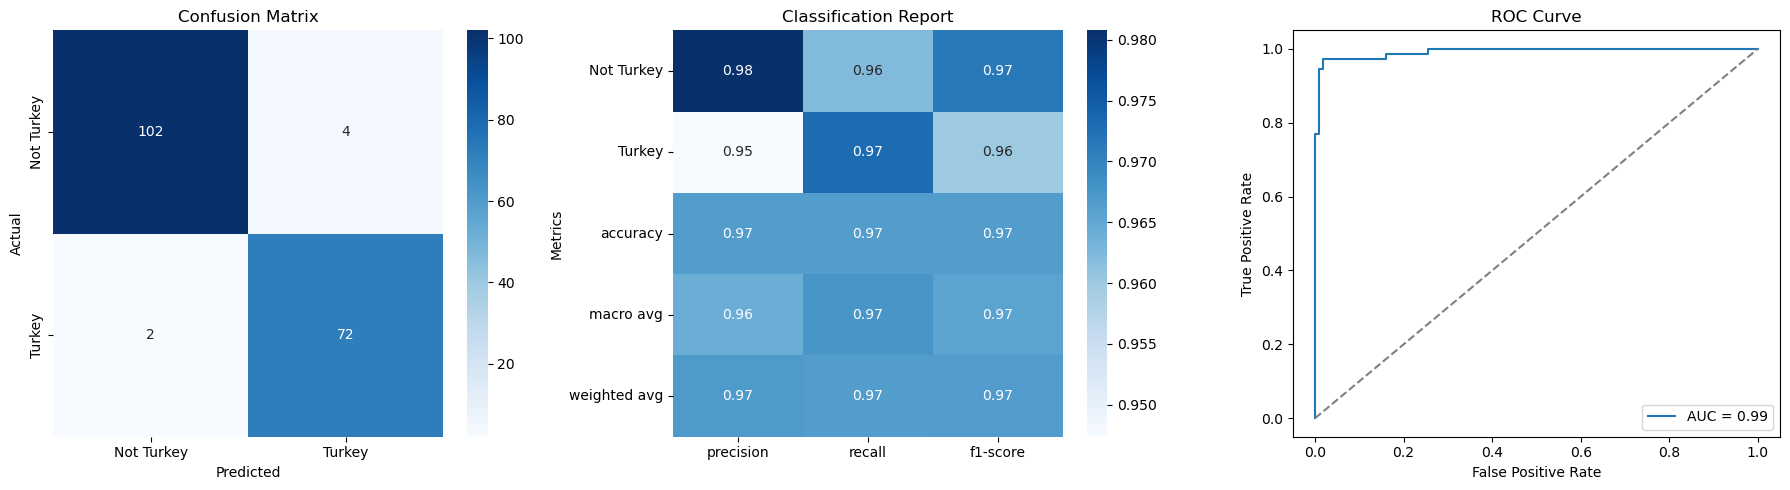

In [14]:
evaluate_model(model, test_dataset)

Mô hình đạt hiệu suất rất cao, AUC tận 0.9922, độ chính xác lên đến 96,67%. Các thông số khác như precision, recall đều cao cho thấy khả năng phân loại của mô hình rất tốt.